**Homework 2**

In this exercise we will retrieve some data from the NOAA webservice and do some data processing on it.

I have included the helper function from the book Notebooks, Chapter 3, 2 - using the weather api

***If you have serious trouble using/acccessing the API do not spend hours figuring it out let me know and worst case I can get you a csv file**

In [4]:

import requests
import pandas as pd

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        A response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'RDBwieNtlQtPFszhHSvIukqJnIJVldda'
        },
        params=payload
    )


def get_item(name, what, endpoint, start=1, end=None):
    """
    Grab the JSON payload for a given field by name using binary search.

    Parameters:
        - name: The item to look for.
        - what: Dictionary specifying what the item in `name` is.
        - endpoint: Where to look for the item.
        - start: The position to start at. We don't need to touch this, but the
                 function will manipulate this with recursion.
        - end: The last position of the items. Used to find the midpoint, but
               like `start` this is not something we need to worry about.

    Returns:
        Dictionary of the information for the item if found otherwise 
        an empty dictionary.
    """
    # find the midpoint which we use to cut the data in half each time
    mid = (start + (end or 1)) // 2
    
    # lowercase the name so this is not case-sensitive
    name = name.lower()
    
    # define the payload we will send with each request
    payload = {
        'datasetid': 'GHCND',
        'sortfield': 'name',
        'offset': mid, # we will change the offset each time
        'limit': 1 # we only want one value back
    }
    
    # make our request adding any additional filter parameters from `what`
    response = make_request(endpoint, {**payload, **what})
    
    if response.ok:
        payload = response.json()

        # if response is ok, grab the end index from the response metadata the first time through
        end = end or payload['metadata']['resultset']['count']
        
        # grab the lowercase version of the current name
        current_name = payload['results'][0]['name'].lower()
        
        # if what we are searching for is in the current name, we have found our item
        if name in current_name:
            return payload['results'][0] # return the found item
        else:
            if start >= end: 
                # if our start index is greater than or equal to our end, we couldn't find it
                return {}
            elif name < current_name:
                # our name comes before the current name in the alphabet, so we search further to the left
                return get_item(name, what, endpoint, start, mid - 1)
            elif name > current_name:
                # our name comes after the current name in the alphabet, so we search further to the right
                return get_item(name, what, endpoint, mid + 1, end)    
    else:
        # response wasn't ok, use code to determine why
        print(f'Response not OK, status: {response.status_code}')

**CODE**
Here is the function from the book to retrieve data. Modify to retrieve the dataset for the two locations in the UAE:

* datasetid - GHCND
* stationid - GHCND:AEM00041194 & GHCND:AE000041196  (look at the datatypeid field for how to include multiple)
* locationid - CITY:AE000003
* For January of 2023

In [5]:
response = make_request(
    'data', 
    {
        'datasetid': 'GHCND',
        'stationid': ['GHCND:AEM00041194','GHCND:AE000041196'],
        'locationid': 'CITY:AE000003',
        'startdate': '2023-01-01',
        'enddate': '2023-01-31',
        'datatypeid': ['TAVG', 'TMAX', 'TMIN'], # average, max, and min temperature
        'units': 'metric',
        'limit': 1000
    }
)
response.status_code

200

In [6]:
#writing the response to a file
with open('weather.json', 'w') as f:
    f.write(response.text)



AttributeError: module 'pandas' has no attribute 'writecsv'

**CODE**
Read the 'results' of the web service call into a Pandas dataframe.

In [7]:
df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2023-01-01T00:00:00,TAVG,GHCND:AE000041196,"H,,S,",20.7
1,2023-01-01T00:00:00,TMAX,GHCND:AE000041196,",,S,",25.2
2,2023-01-01T00:00:00,TMIN,GHCND:AE000041196,",,S,",14.9
3,2023-01-01T00:00:00,TAVG,GHCND:AEM00041194,"H,,S,",22.3
4,2023-01-01T00:00:00,TMAX,GHCND:AEM00041194,",,S,",25.5


In [8]:
#write the df to a csv file
df.to_csv('weather.csv', index=False)

**CODE**

Use the "info" dataframe function to check the type of the columns

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        154 non-null    object 
 1   datatype    154 non-null    object 
 2   station     154 non-null    object 
 3   attributes  154 non-null    object 
 4   value       154 non-null    float64
dtypes: float64(1), object(4)
memory usage: 6.1+ KB


**CODE**

Data Type Conversion - change the column data types for:

* date - datetime
* datatype - categorical
* station - categorical

In [18]:
df.date = pd.to_datetime(df.date)

df.datatype = df.datatype.astype('category')

df.station = df.station.astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        154 non-null    datetime64[ns]
 1   datatype    154 non-null    category      
 2   station     154 non-null    category      
 3   attributes  154 non-null    object        
 4   value       154 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(1)
memory usage: 4.3+ KB


**CODE**

Use the describe function to summarize data on the CATEGORICAL columns only
Get a count for each unique value of datatype

In [48]:
df.describe(include='category')

,datatype,station
count,154,154
unique,3,2
top,TAVG,GHCND:AE000041196
freq,62,77


In [49]:
df.station.value_counts()

station
GHCND:AE000041196    77
GHCND:AEM00041194    77
Name: count, dtype: int64

In [50]:
df.datatype.value_counts()

datatype
TAVG    62
TMAX    54
TMIN    38
Name: count, dtype: int64

**CODE**
 
Rename the value (temperature) column to temp_C

Create a new column called temp_F that calculated Farenheit on the formula (df.temp_C * 9/5) + 32

In [22]:
#rename value column to temp_C
df.rename(columns={'value': 'temp_C'}, inplace=True)

In [25]:
#create a new column called temp_F and convert temp_C to Fahrenheit
df['temp_F'] = df.temp_C * 9/5 + 32


In [26]:
df.head()

,date,datatype,station,attributes,temp_C,temp_F
0,2023-01-01,TAVG,GHCND:AE000041196,"H,,S,",20.7,69.26
1,2023-01-01,TMAX,GHCND:AE000041196,",,S,",25.2,77.36
2,2023-01-01,TMIN,GHCND:AE000041196,",,S,",14.9,58.82
3,2023-01-01,TAVG,GHCND:AEM00041194,"H,,S,",22.3,72.14
4,2023-01-01,TMAX,GHCND:AEM00041194,",,S,",25.5,77.90


**CODE**

Let's analyze the data some.

Get the 10 hottest (TMAX) days, ordered by TMAX desc and Date asc

In [38]:
# get a dataframe from df where datatype = TMAX and station = GHCND:AEM00041194
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True], ignore_index=True).head(10)

,date,datatype,station,attributes,temp_C,temp_F
0,2023-01-17,TMAX,GHCND:AEM00041194,",,S,",29.4,84.92
1,2023-01-10,TMAX,GHCND:AEM00041194,",,S,",29.3,84.74
2,2023-01-10,TMAX,GHCND:AE000041196,",,S,",29.0,84.20
3,2023-01-31,TMAX,GHCND:AEM00041194,",,S,",28.7,83.66
4,2023-01-05,TMAX,GHCND:AEM00041194,",,S,",28.6,83.48
5,2023-01-05,TMAX,GHCND:AE000041196,",,S,",28.1,82.58
6,2023-01-04,TMAX,GHCND:AEM00041194,",,S,",27.7,81.86
7,2023-01-02,TMAX,GHCND:AEM00041194,",,S,",26.9,80.42
8,2023-01-03,TMAX,GHCND:AE000041196,",,S,",26.4,79.52
9,2023-01-03,TMAX,GHCND:AEM00041194,",,S,",26.4,79.52


**CODE**

Get the 10 coldest (TMIN) days, ordered by TMIN asc and Date asc

In [51]:
df[df.datatype == 'TMIN'].sort_values(by=['temp_C', 'date'], ascending=[True, True], ignore_index=True).head(10)

,date,datatype,station,attributes,temp_C,temp_F
0,2023-01-29,TMIN,GHCND:AE000041196,",,S,",11.5,52.70
1,2023-01-31,TMIN,GHCND:AE000041196,",,S,",12.0,53.60
2,2023-01-22,TMIN,GHCND:AE000041196,",,S,",12.2,53.96
3,2023-01-30,TMIN,GHCND:AE000041196,",,S,",12.5,54.50
4,2023-01-21,TMIN,GHCND:AE000041196,",,S,",12.8,55.04
5,2023-01-24,TMIN,GHCND:AE000041196,",,S,",12.8,55.04
6,2023-01-20,TMIN,GHCND:AE000041196,",,S,",12.9,55.22
7,2023-01-13,TMIN,GHCND:AE000041196,",,S,",13.3,55.94
8,2023-01-12,TMIN,GHCND:AE000041196,",,S,",13.5,56.30
9,2023-01-29,TMIN,GHCND:AEM00041194,",,S,",13.7,56.66


**CODE**

* Create a new dataframe, indexed_df, that includes ONLY the TMAX data for station GHCND:AEM00041194

* Make the date column the index for this new dataframe

In [54]:
indexed_df_max = df[df.datatype == 'TMAX'][df.station == 'GHCND:AEM00041194'].set_index('date')
indexed_df_max.head()

/var/folders/s4/35mz08191h37fr7zq4g0m_d40000gn/T/ipykernel_3844/365188312.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indexed_df_max = df[df.datatype == 'TMAX'][df.station == 'GHCND:AEM00041194'].set_index('date')


,datatype,station,attributes,temp_C,temp_F
date,,,,,
2023-01-01,TMAX,GHCND:AEM00041194,",,S,",25.5,77.90
2023-01-02,TMAX,GHCND:AEM00041194,",,S,",26.9,80.42
2023-01-03,TMAX,GHCND:AEM00041194,",,S,",26.4,79.52
2023-01-04,TMAX,GHCND:AEM00041194,",,S,",27.7,81.86
2023-01-05,TMAX,GHCND:AEM00041194,",,S,",28.6,83.48


**CODE**

We haven't done much graphing yets but use the Padas Dataframe built in function "plot" to plot the temp_C over time. Might not work if you dont have the date column as the index.

This is/can be as simple as a single line of code, dont go crazy

<Axes: xlabel='date'>

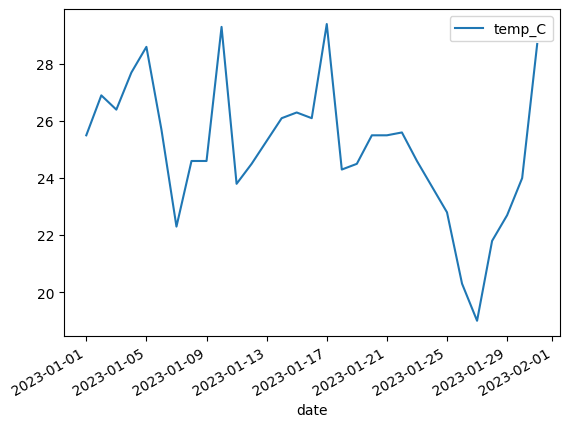

In [55]:
# graph temp_C for the datatype TMAX
indexed_df_max.temp_C.plot(legend=True)

**CODE**

Create another dataframe from the original DF that contains only TMIN for the station GHCND:AEM00041194

Set the date column to be the index

In [59]:
indexed_df_min = df[df.datatype == 'TMIN'][df.station == 'GHCND:AEM00041194'].set_index('date')
indexed_df_min.head()



/var/folders/s4/35mz08191h37fr7zq4g0m_d40000gn/T/ipykernel_3844/2482496974.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indexed_df_min = df[df.datatype == 'TMIN'][df.station == 'GHCND:AEM00041194'].set_index('date')


,datatype,station,attributes,temp_C,temp_F
date,,,,,
2023-01-01,TMIN,GHCND:AEM00041194,",,S,",18.6,65.48
2023-01-04,TMIN,GHCND:AEM00041194,",,S,",19.9,67.82
2023-01-05,TMIN,GHCND:AEM00041194,",,S,",20.6,69.08
2023-01-08,TMIN,GHCND:AEM00041194,",,S,",17.9,64.22
2023-01-09,TMIN,GHCND:AEM00041194,",,S,",18.5,65.30


**CODE**

Plot the TMIN and TMAX dataframes together. This is as simple as calling the plot function on each dataframe and it should appear on the same graph

<Axes: xlabel='date'>

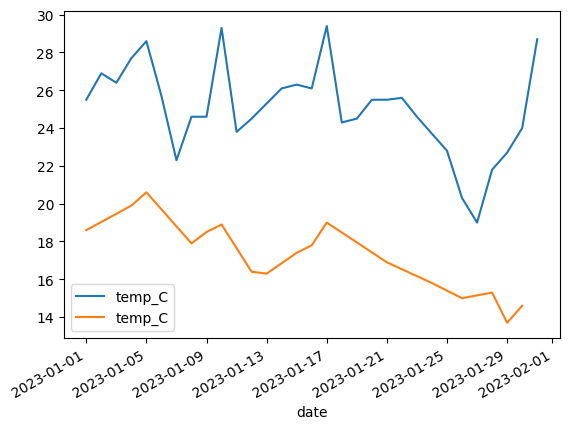

In [60]:
# plot indexed_df_2 temp_C and indexed_df temp_C on the same graph
indexed_df_max.temp_C.plot(legend=True)
indexed_df_min.temp_C.plot(legend=True)
